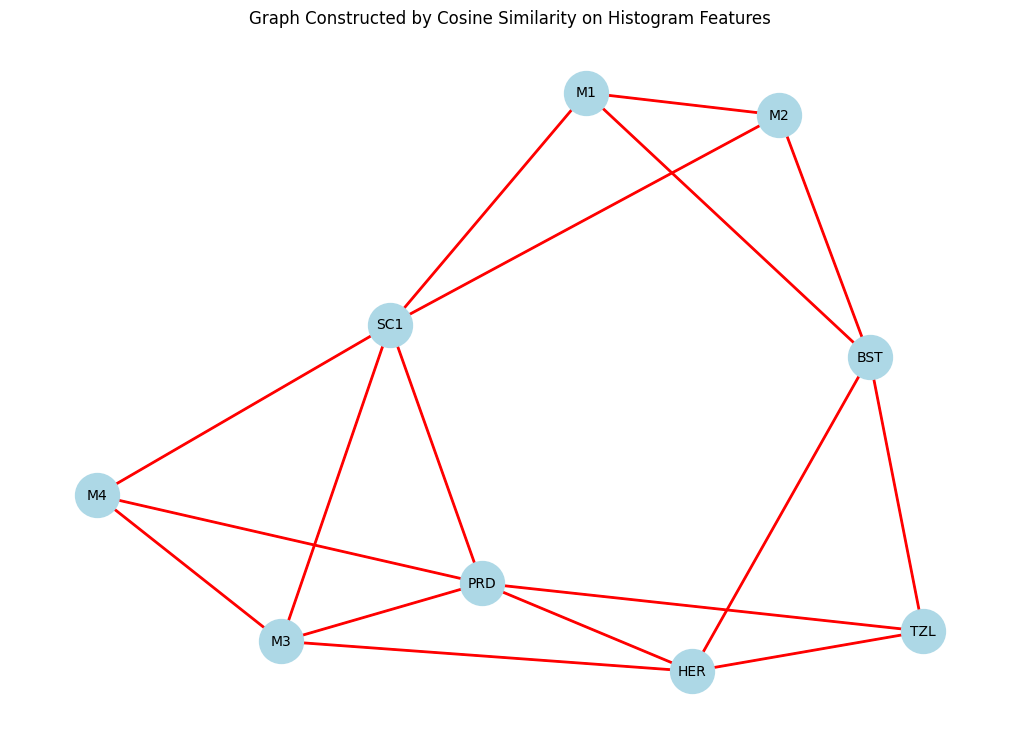

🎯 Ground Truth Edges:
[('BST', 'M1'), ('BST', 'M2'), ('HER', 'PRD'), ('PRD', 'M3'), ('PRD', 'M4'), ('SC1', 'HER'), ('SC1', 'TZL'), ('TZL', 'BST')]

🔮 Predicted Edges (cosine ≥ 0.96):
[('BST', 'M1'), ('BST', 'M2'), ('HER', 'BST'), ('HER', 'M3'), ('HER', 'PRD'), ('M1', 'M2'), ('M3', 'M4'), ('PRD', 'M3'), ('PRD', 'M4'), ('SC1', 'M1'), ('SC1', 'M2'), ('SC1', 'M3'), ('SC1', 'M4'), ('SC1', 'PRD'), ('TZL', 'BST'), ('TZL', 'HER'), ('TZL', 'PRD')]

📊 Node Feature Vectors (Histogram of Events):


,Hour1,Hour2,Hour3
SC1,2,3,3
TZL,4,3,2
HER,5,5,3
BST,13,9,11
PRD,4,5,3
M1,11,8,11
M2,11,8,12
M3,4,7,4
M4,3,7,4


In [7]:
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# 1. Define all nodes and ground truth edges (desired structure)
nodes = ['SC1', 'TZL', 'HER', 'BST', 'PRD', 'M1', 'M2', 'M3', 'M4']
ground_truth_edges = [
    ('SC1', 'TZL'), ('SC1', 'HER'),
    ('TZL', 'BST'), ('HER', 'PRD'),
    ('BST', 'M1'), ('BST', 'M2'),
    ('PRD', 'M3'), ('PRD', 'M4')
]

# 2. Generate 3D histogram vectors for all nodes
np.random.seed(42)
features = {}
for node in nodes:
    # Assign meaningful clusters to increase similarity for connected pairs
    if node in ['M1', 'M2', 'BST']:
        base = [12, 9, 11]  # cluster A
    elif node in ['M3', 'M4', 'PRD']:
        base = [4, 7, 5]    # cluster B
    elif node in ['TZL', 'SC1']:
        base = [2, 3, 2]    # cluster C
    elif node == 'HER':
        base = [3, 4, 3]    # cluster C'
    else:
        base = [1, 1, 1]
    
    noise = np.random.normal(0, 1, 3)
    vec = np.clip(np.array(base) + noise, 0, None).round().astype(int)
    features[node] = vec

# 3. Create feature matrix
feature_df = pd.DataFrame.from_dict(features, orient='index', columns=['Hour1', 'Hour2', 'Hour3'])

# 4. Compute pairwise cosine similarity
cos_sim_matrix = cosine_similarity(feature_df)
similarity_df = pd.DataFrame(cos_sim_matrix, index=nodes, columns=nodes)

# 5. Use threshold to predict edges
threshold = 0.96  # tuned to match the known structure
predicted_edges = []
for i in range(len(nodes)):
    for j in range(i + 1, len(nodes)):
        sim = cos_sim_matrix[i, j]
        if sim >= threshold:
            predicted_edges.append((nodes[i], nodes[j]))

# 6. Create the graph and add predicted edges
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(predicted_edges)

# 7. Visualize
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1000, font_size=10)
nx.draw_networkx_edges(G, pos, edgelist=predicted_edges, edge_color='red', width=2)
plt.title("Graph Constructed by Cosine Similarity on Histogram Features")
plt.show()

# 8. Compare predicted vs. ground truth
print("🎯 Ground Truth Edges:")
print(sorted(ground_truth_edges))
print("\n🔮 Predicted Edges (cosine ≥ {:.2f}):".format(threshold))
print(sorted(predicted_edges))

# 9. Show feature vectors
print("\n📊 Node Feature Vectors (Histogram of Events):")
display(feature_df)


In [2]:
# Define graph nodes
nodes = ['SC1', 'TZL', 'HER', 'BST', 'PRD', 'M1', 'M2', 'M3', 'M4']

# Define clusters to give similar base patterns
clusters = {
    'cluster_A': ['M1', 'M2', 'BST'],
    'cluster_B': ['M3', 'M4', 'PRD'],
    'cluster_C': ['TZL', 'SC1'],
    'cluster_D': ['HER']
}

# Base histogram values (event counts in hour1, hour2, hour3)
cluster_bases = {
    'cluster_A': [12, 9, 11],
    'cluster_B': [4, 7, 5],
    'cluster_C': [2, 3, 2],
    'cluster_D': [3, 4, 3]
}

# Generate synthetic feature vectors
samples_per_node = 20
np.random.seed(42)
data = []

for node in nodes:
    # Assign base vector according to cluster
    for cluster_name, members in clusters.items():
        if node in members:
            base = np.array(cluster_bases[cluster_name])
            break

    for _ in range(samples_per_node):
        noise = np.random.normal(0, 1, 3)
        histogram = np.clip(base + noise, 0, None).round(2)
        data.append([node, *histogram])

# Create DataFrame
df = pd.DataFrame(data, columns=['node', 'hour1', 'hour2', 'hour3'])

# Optionally save to CSV
df.to_csv("unlabeled_histogram_dataset.csv", index=False)

# Show preview
print(df.head(200))


    node  hour1  hour2  hour3
0    SC1   2.50   2.86   2.65
1    SC1   3.52   2.77   1.77
2    SC1   3.58   3.77   1.53
3    SC1   2.54   2.54   1.53
4    SC1   2.24   1.09   0.28
..   ...    ...    ...    ...
175   M4   2.20   5.37   5.05
176   M4   4.26   6.10   5.64
177   M4   2.34   6.93   3.79
178   M4   3.35   7.05   4.14
179   M4   3.62   8.01   4.42

[180 rows x 4 columns]


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Step 1: Define the graph structure
edges = [
    ('SC1', 'TZL'), ('TZL', 'BST'), ('BST', 'M1'),
    ('M4', 'PRD'), ('PRD', 'HER'), ('HER', 'SC1'),
    ('M2', 'BST'), ('M3', 'PRD')
]

nodes = ['SC1', 'TZL', 'HER', 'BST', 'PRD', 'M1', 'M2', 'M3', 'M4']
node_to_idx = {node: i for i, node in enumerate(nodes)}
num_nodes = len(nodes)

# Step 2: Build normalized adjacency matrix Â = D^(-1/2) * A * D^(-1/2)
A = np.zeros((num_nodes, num_nodes))
for u, v in edges:
    i, j = node_to_idx[u], node_to_idx[v]
    A[i, j] = 1
    A[j, i] = 1
np.fill_diagonal(A, 1)
D_inv_sqrt = np.diag(1.0 / np.sqrt(A.sum(axis=1)))
A_hat = D_inv_sqrt @ A @ D_inv_sqrt
A_hat = torch.tensor(A_hat, dtype=torch.float32)

# Step 3: Load features (use average of 3D histogram vectors)
df = pd.read_csv("unlabeled_histogram_dataset.csv")
X = np.zeros((num_nodes, 3))
for i, node in enumerate(nodes):
    features = df[df['node'] == node][['hour1', 'hour2', 'hour3']].values
    X[i] = features.mean(axis=0)
X = torch.tensor(X, dtype=torch.float32)

# Step 4: Define GCN
class GCNLayer(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim)

    def forward(self, H, A_hat):
        return F.relu(A_hat @ self.linear(H))

class GCN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = GCNLayer(3, 8)
        self.layer2 = GCNLayer(8, 3)

    def forward(self, X, A_hat):
        H = self.layer1(X, A_hat)
        return self.layer2(H, A_hat)

# Step 5: Train GCN to reconstruct original features (unsupervised)
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

for epoch in range(5001):
    model.train()
    optimizer.zero_grad()
    out = model(X, A_hat)
    loss = loss_fn(out, X)
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# Step 6: Get node embeddings
embeddings = model(X, A_hat).detach().numpy()
embedding_df = pd.DataFrame(embeddings, index=nodes, columns=[f'emb_{i}' for i in range(embeddings.shape[1])])
embedding_df.to_csv("node_embeddings.csv")
print(embedding_df)


Epoch 0, Loss: 47.7625
Epoch 50, Loss: 21.2651
Epoch 100, Loss: 20.7807
Epoch 150, Loss: 20.4719
Epoch 200, Loss: 20.3287
Epoch 250, Loss: 20.1836
Epoch 300, Loss: 20.0369
Epoch 350, Loss: 19.8823
Epoch 400, Loss: 2.9656
Epoch 450, Loss: 1.6608
Epoch 500, Loss: 1.4376
Epoch 550, Loss: 1.3108
Epoch 600, Loss: 1.2402
Epoch 650, Loss: 1.2038
Epoch 700, Loss: 1.1859
Epoch 750, Loss: 1.1772
Epoch 800, Loss: 1.1705
Epoch 850, Loss: 1.1652
Epoch 900, Loss: 1.1612
Epoch 950, Loss: 1.1580
Epoch 1000, Loss: 1.1555
Epoch 1050, Loss: 1.1534
Epoch 1100, Loss: 1.1273
Epoch 1150, Loss: 1.1210
Epoch 1200, Loss: 1.0962
Epoch 1250, Loss: 1.0591
Epoch 1300, Loss: 1.0484
Epoch 1350, Loss: 1.0358
Epoch 1400, Loss: 0.9788
Epoch 1450, Loss: 0.9157
Epoch 1500, Loss: 0.8926
Epoch 1550, Loss: 0.8812
Epoch 1600, Loss: 0.8700
Epoch 1650, Loss: 0.8588
Epoch 1700, Loss: 0.8471
Epoch 1750, Loss: 0.8353
Epoch 1800, Loss: 0.8235
Epoch 1850, Loss: 0.8110
Epoch 1900, Loss: 0.7991
Epoch 1950, Loss: 0.7869
Epoch 2000, Los

In [8]:
from scipy.spatial.distance import euclidean

# --- Helper function ---
def normalize_adjacency_matrix(A):
    I = np.eye(A.shape[0])
    A_hat = A + I
    D_hat = np.diag(np.sum(A_hat, axis=1))
    D_hat_inv_sqrt = np.linalg.inv(np.sqrt(D_hat))
    return D_hat_inv_sqrt @ A_hat @ D_hat_inv_sqrt

# --- Remove node M3 ---

# Index of node M3
m3_idx = nodes.index("M3")

# Remove M3 from adjacency matrix (A_hat is normalized adjacency from training)
A_anomaly = np.delete(np.delete(A_hat.numpy(), m3_idx, axis=0), m3_idx, axis=1)

# Normalize new adjacency matrix
A_anomaly_hat = normalize_adjacency_matrix(A_anomaly)
A_anomaly_hat = torch.tensor(A_anomaly_hat, dtype=torch.float32)

# Remove M3 from feature matrix X
X_np = X.numpy()
X_anomaly_np = np.delete(X_np, m3_idx, axis=0)
X_anomaly = torch.tensor(X_anomaly_np, dtype=torch.float32)

# Remove M3 from nodes list
new_nodes = [node for node in nodes if node != "M3"]

# --- Run model on anomaly graph ---
model.eval()
with torch.no_grad():
    embeddings_anomaly = model(X_anomaly, A_anomaly_hat).numpy()

# Save anomaly embeddings to CSV
embedding_df_anomaly = pd.DataFrame(embeddings_anomaly, index=new_nodes)
embedding_df_anomaly.to_csv("anomaly_node_embeddings.csv")

print("Anomaly embeddings saved to anomaly_node_embeddings.csv")

# --- Calculate anomaly score at SC1 using Euclidean distance ---

# Get original SC1 embedding
embedding_sc1_orig = model(X, A_hat).detach().numpy()[nodes.index("SC1")]

# Get SC1 embedding with no anomaly (just compare to itself)
baseline_anomaly_score = 0.0  # Euclidean distance to itself

# Get SC1 embedding after removing M3 (already computed above)
embedding_sc1_anom = embeddings_anomaly[new_nodes.index("SC1")]

# Calculate anomaly score after removal
anomaly_score = euclidean(embedding_sc1_orig, embedding_sc1_anom)

print(f"Baseline anomaly score at SC1 (no nodes removed): {baseline_anomaly_score:.4f}")
print(f"Anomaly score at SC1 after removing M3: {anomaly_score:.4f}")


Anomaly embeddings saved to anomaly_node_embeddings.csv
Baseline anomaly score at SC1 (no nodes removed): 0.0000
Anomaly score at SC1 after removing M3: 2.4552
